# Library loading

In [1]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib, torch, time, h5py
import numpy as np

from sklearn.metrics import mean_squared_error

import neuravi

import structupy as spy
import viscopy as vp

device = torch.device('cpu') #get_default_device()
print(device)

import mpltern
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

cpu


# Load dataset

In [2]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Function to bag models

This object will help bagging results from 10 models and calling their predictions.

In [3]:
class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_n")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg', 'tvf')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

# Loading the models

In [4]:
path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

# Test figure

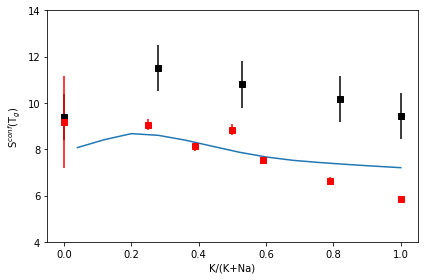

In [5]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")

plt.tight_layout()

# Errors on viscosity

In [6]:
criterion = torch.nn.MSELoss()

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

ag_after_train = np.sqrt(mean_squared_error(y_ag_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
ag_after_valid = np.sqrt(mean_squared_error(y_ag_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
ag_after_test = np.sqrt(mean_squared_error(y_ag_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('AG train loss after training {0:.2f}'.format(ag_after_train))
print('AG valid loss after training {0:.2f}'.format(ag_after_valid))
print('AG test loss after training {0:.2f}'.format(ag_after_test))
print('')

tvf_after_train = np.sqrt(mean_squared_error(y_tvf_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
tvf_after_valid = np.sqrt(mean_squared_error(y_tvf_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
tvf_after_test  = np.sqrt(mean_squared_error(y_tvf_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('TVF train loss after training {0:.2f}'.format(tvf_after_train))
print('TVF valid loss after training {0:.2f}'.format(tvf_after_valid))
print('TVF test loss after training {0:.2f}'.format(tvf_after_test))
print('')

myega_after_train = np.sqrt(mean_squared_error(y_myega_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
myega_after_valid = np.sqrt(mean_squared_error(y_myega_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
myega_after_test = np.sqrt(mean_squared_error(y_myega_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('myega train loss after training {0:.2f}'.format(myega_after_train))
print('myega valid loss after training {0:.2f}'.format(myega_after_valid))
print('myega test loss after training {0:.2f}'.format(myega_after_test))
print('')

am_after_train = np.sqrt(mean_squared_error(y_am_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
am_after_valid = np.sqrt(mean_squared_error(y_am_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
am_after_test = np.sqrt(mean_squared_error(y_am_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('am train loss after training {0:.2f}'.format(am_after_train))
print('am valid loss after training {0:.2f}'.format(am_after_valid))
print('am test loss after training {0:.2f}'.format(am_after_test))
print('')

cg_after_train = np.sqrt(mean_squared_error(y_cg_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
cg_after_valid = np.sqrt(mean_squared_error(y_cg_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
cg_after_test = np.sqrt(mean_squared_error(y_cg_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('cg train loss after training {0:.2f}'.format(cg_after_train))
print('cg valid loss after training {0:.2f}'.format(cg_after_valid))
print('cg test loss after training {0:.2f}'.format(cg_after_test))
print('')

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('density train loss after training {0:.3f}'.format(ese_density_train))
print('density valid loss after training {0:.3f}'.format(ese_density_valid))
print('density test loss after training {0:.3f}'.format(ese_density_test))
print('')

print('refractive index train loss after training {0:.3f}'.format(ese_ri_train))
print('refractive index valid loss after training {0:.3f}'.format(ese_ri_valid))
print('refractive index test loss after training {0:.3f}'.format(ese_ri_test))
print('')


AG train loss after training 0.25
AG valid loss after training 0.30
AG test loss after training 0.46

TVF train loss after training 0.24
TVF valid loss after training 0.35
TVF test loss after training 0.45

myega train loss after training 0.25
myega valid loss after training 0.39
myega test loss after training 0.46

am train loss after training 0.24
am valid loss after training 0.36
am test loss after training 0.46

cg train loss after training 0.22
cg valid loss after training 0.36
cg test loss after training 0.45

density train loss after training 0.007
density valid loss after training 0.014
density test loss after training 0.009

refractive index train loss after training 0.003
refractive index valid loss after training 0.003
refractive index test loss after training 0.005



# Compare with Giordano

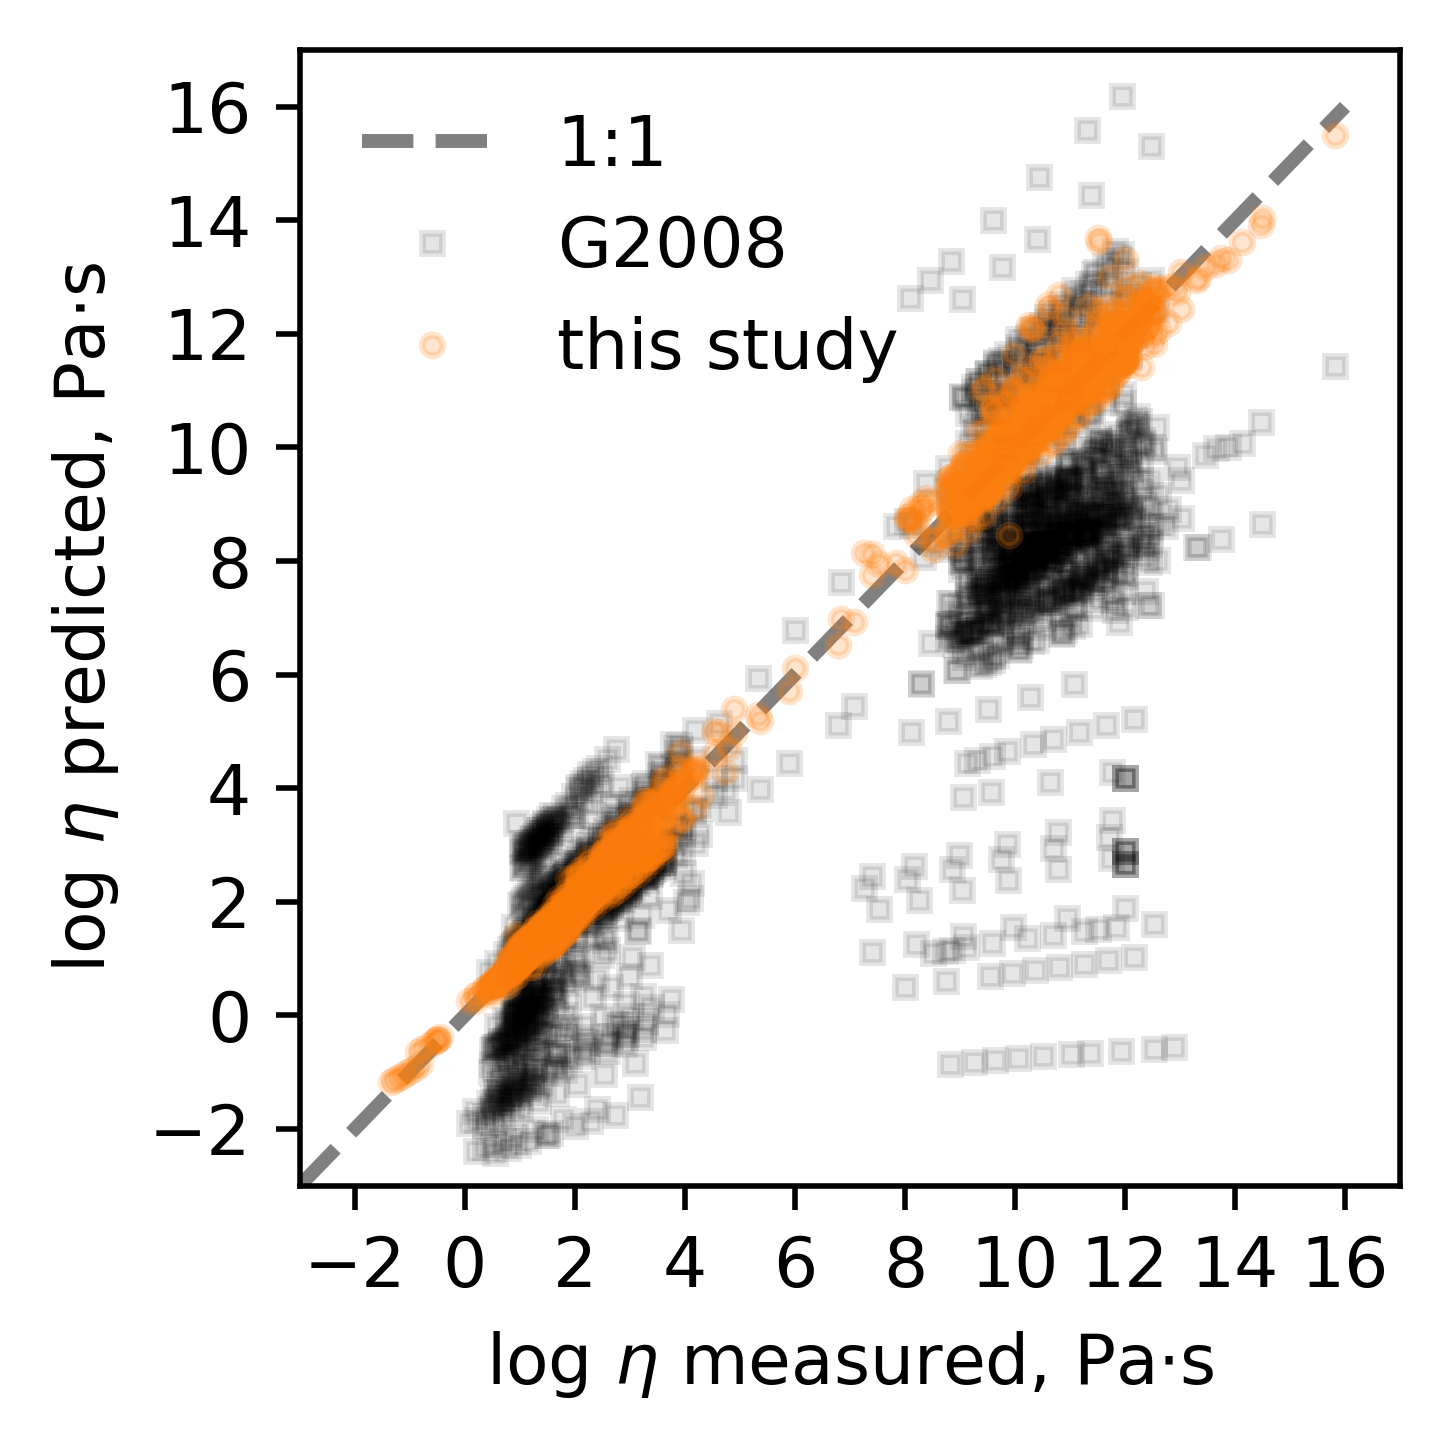

In [7]:
datas_ = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
datas_ = spy.chimie_control(datas_)
Gmodel = vp.G2008(datas_)

plt.figure(figsize=(3.,3.),dpi=500)

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.plot(datas_.viscosity,Gmodel[0],"ks",markersize=3,alpha=0.1,label="G2008")

plt.xticks([-2,0,2,4,6,8,10,12,14,16])
plt.yticks([-2,0,2,4,6,8,10,12,14,16])

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.ylabel("log $\eta$ predicted, Pa$\cdot$s")
plt.xlabel("log $\eta$ measured, Pa$\cdot$s")

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("./figures/Comp_G2008.png")

plt.plot(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.mean(axis=1),"o",color="C1",markersize=3,alpha=0.2,label="this study")
plt.plot(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.mean(axis=1),"o",color="C1",markersize=3,alpha=0.2)
plt.plot(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.mean(axis=1),"o",color="C1",markersize=3,alpha=0.2)
plt.legend(frameon=False)
plt.savefig("./figures/Comp_G2008_LL.png")


# For presentation

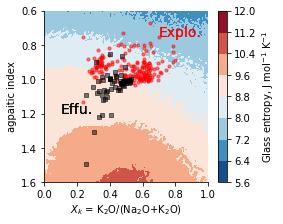

In [12]:
# Loading the data from Di Genova 2017
dataset_DG2017 = pd.read_excel("./data/dev/nature24488-s2-modified.xlsx")
dataset_DG2017.head()

dataset_DG2017 = dataset_DG2017.groupby('Location').mean().reset_index()

nb_samples = 20000

X_rh = pd.DataFrame()
X_rh["sio2"] = np.random.random_sample(nb_samples)*0.04 + 0.78

R_MAl = np.random.random_sample(nb_samples)*0.4 + 0.3 # ratio of alkalis to Al
R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

X_rh["al2o3"] = (1.0 - R_MAl)*(1-X_rh["sio2"])
X_rh["na2o"] = (1-X_rh["sio2"]-X_rh["al2o3"])*(1-R_XK)
X_rh["k2o"] = (1-X_rh["sio2"]-X_rh["al2o3"]-X_rh["na2o"])

rh_sctg = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)
rh_be = neuralmodel.predict("be",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

Raman_rh = neuralmodel.predict("raman_pred",X_rh.values).mean(axis=2)

Rr_rh = np.trapz(Raman_rh[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_rh[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

#plotted = Rr_rh.reshape(-1)
plotted = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

plt.figure(figsize=(4,3.22))
ax = plt.subplot()

plt.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
plt.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

plt.annotate("Effu.", xy=(0.1,1.2),xycoords="data",color="black",fontsize=14)
plt.annotate("Explo.", xy=(0.7,0.75),xycoords="data",color="red",fontsize=14)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"agpaitic index")
plt.xlim(0,1)
plt.ylim(1.6,0.6)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/agpaitic.pdf')


tc1 = plt.tricontourf(X_rh.loc[:,"k2o"]/(X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"]),
                (X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"])/(X_rh.loc[:,"al2o3"]), 
                plotted.reshape(-1), 
                levels=6, cmap="RdBu_r",antialiased=False)

cbar = plt.colorbar()

cbar.set_label('Glass entropy, J mol$^{-1}$ K$^{-1}$')

plt.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
plt.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

plt.annotate("Effu.", xy=(0.1,1.2),xycoords="data",color="black",fontsize=14)
plt.annotate("Explo.", xy=(0.7,0.75),xycoords="data",color="red",fontsize=14)

plt.xlim(0,1)
plt.ylim(1.6,0.6)

plt.tight_layout()

plt.savefig('./figures/agpaitic_entropy.pdf')